# Notebook Setup
Installs necessary requirements and configures proper notebook behavior  
Note: The notebook assumes you are using the base conda environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
    
print("Notebook setup has completed")

Notebook setup has completed


# Environment Setup
Downloads configured dataset and performs necessary environment bootstrapping

In [8]:
from bootstrap import setup


# Please rename .env-template to .env and adjust values as needed
setup()

print("Environment setup has completed")

del setup

Environment setup has completed


# Sandbox
Available data split into training, testing, and validation sets

In [12]:
from preprocessing import get_dataframe, get_subsets


df = get_dataframe()  # In the form [features, labels]

# TODO: Transform raw text into a representation suitable for a MLP
# df can has as many feature columns as needed, but the last column must be the label column

X_train, X_test, X_validate, y_train, y_test, y_validate = get_subsets(df)


# Implementation

In [244]:
from typing import Callable, Iterable, Union

import numpy as np


class MultiLayerPerceptron:
    def __init__(
        self,
        epochs: int,
        lr: Union[float, Callable[int, float]],
        hidden_layers: int,
        neurons_per_layer: int,
        activation: Union[Callable, Iterable[Callable]]
    ):
        if isinstance(activation, Iterable):
            assert len(activation) == hidden_layers
        
        self.num_epochs = epochs
        self.lr = (lambda x: lr) if isinstance(lr, float) else lr
        self.hidden_layers = hidden_layers
        self.neurons_per_layer = neurons_per_layer
        self.activation = activation
        self._units = None
    
    def epochs(self):
        for i in range(self.num_epochs):
            yield i, self.lr(i)
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._units = []
        for _ in range(self.hidden_layers):
            layer = [SinglePerceptron(dimensions=X.shape[1]) for _ in range(self.neurons_per_layer)]
            self._units.append(layer)
        print(self._units)
        
        
        for epoch_num, lr in self.epochs():
            pass
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        pass



In [245]:
p = TwoDimProblem(5)
X, y = p.createData(2, 0, 400)
m = MultiLayerPerceptron(1, 0.001, 2, 3, sigmoid)
m.fit(X,y)

[[Sigmoid at 2354698626976, Sigmoid at 2354706880816, Sigmoid at 2354706879520], [Sigmoid at 2354706884992, Sigmoid at 2354706887488, Sigmoid at 2354706880864]]


In [240]:
import numpy as np
def sigmoid(X: np.ndarray):
    return 1 / (1 + np.exp(-X))
def dSigmoid(X: np.ndarray):
    a = 1 / (1 + np.exp(-X))
    return a*(1-a)

In [243]:
class SinglePerceptron:
    def __init__(self, 
                 dimensions: int,
                 activation: Callable[np.ndarray, np.ndarray] = sigmoid, 
                 dActivation: Callable[np.ndarray, np.ndarray] = dSigmoid,
                 ):
        self.w = np.zeros(dimensions)
        self.dimensions = dimensions
        self.activation = activation
        self.dActivation = dActivation
    def predict(self, X: np.ndarray):
        return np.where(self.w[0] + np.dot(X, self.w[1:]) > 0, 1, 0)
    def feedfoward(self, X: np.ndarray):
        return self.activation(self.w[0] + np.dot(X, self.w[1:]))
    def backprop(self, X: np.ndarray, delta: np.ndarray, lr):
        self.w += lr * delta * X
    def __str__(self):
        return f'Perceptron: dim={self.dimensions}'
    def __repr__(self):
        return f'Perceptron at {id(self)}'
#     def fit(self, X, y, lr=0.01, epochs=5):
#         extendedX = np.append(np.ones((X.shape[0],1)), X, axis=1)
#         self.w = np.zeros(extendedX.shape[1])
#         for _ in tqdm(range(epochs)):
#             error = y - self.activation(np.dot(extendedX, self.w))
#             dw = np.sum(extendedX.T * error, axis=1)
#             self.w += lr * dw
        

#### Decision Boundary as a function:

$w_0 + x \cdot w_1 + y \cdot w_2 > 0 $  
$w_0 + x \cdot w_1 > - y \cdot w_2 $  
$-\frac{w_0}{w_2} - \frac{w_1}{w_2} x > y $


# Experiments on 2d data

In [223]:
# generate noisy data
import matplotlib.pyplot as plt
from sympy import lambdify, sympify

class TwoDimProblem:
    def __init__(self, value_range: int):
        self.seperator = None
        self.data = None
        self.value_range = value_range 
        self.labels = None
        
    def createData(self, soln_rank: int, noise_frac: float, samples: int) -> np.ndarray:
        '''Create data of length samples that is seperable with a line of given rank with some noise'''
        assert 0 <= noise_frac < 1
        assert soln_rank > 0
        RANGE = self.value_range
        coefficients = np.random.randint(-RANGE, RANGE+1, size=(soln_rank+1))
        expression = '+'.join([f'{c}*x**{i}' for i,c in enumerate(coefficients)])
        self.seperator = lambdify('x', sympify(expression))
        self.data = (np.random.rand(samples,2) - 0.5)*RANGE*2
        self.labels = [1 if (point[1] > self.seperator(point[0])) else 0 for point in self.data]
        
        noise_pts = int(samples * noise_frac)
        self.labels[:noise_pts] = np.mod(np.array(self.labels[:noise_pts]) + 1, 2)
        
        return self.data, self.labels
    
    def plotData(self, show_seperator=False):
        RANGE = self.value_range
        plt.scatter(self.data[:,0], self.data[:,1], c=['b' if l==1 else 'orange' for l in self.labels])
        if show_seperator:
            x = np.linspace(-RANGE, RANGE, 1000)
            x = np.array([i for i in x if -RANGE*1.5 <= self.seperator(i) <= RANGE*1.5])
            y = self.seperator(x)
            plt.plot(x, y, c='black')
        plt.show()
        
    def plotPred(self, y_pred, seperator=None, show_correct=True):
        RANGE = self.value_range
        assert len(y_pred) == len(self.labels)
        print(f"Accuracy = {np.mean(y_pred == self.labels)}")
        scatter_colors = []
        for p, a in zip(y_pred, self.labels):
            if not p == a and a == 0:
                scatter_colors.append('#990000')
            elif  not p == a and a == 1:
                scatter_colors.append('r')
            elif p == a == 1:
                scatter_colors.append('lightgreen')
            else:
                scatter_colors.append('g')
                
        plt.scatter(self.data[:,0], self.data[:,1], c=scatter_colors)
        if seperator is not None:
            x = np.linspace(-RANGE, RANGE, 1000)
            x = np.array([i for i in x if -RANGE*1.5 <= seperator(i) <= RANGE*1.5])
            y = seperator(x)
            plt.plot(x, y, c='black')
        if show_correct:
            x = np.linspace(-RANGE, RANGE, 1000)
            x = np.array([i for i in x if -RANGE*1.5 <= self.seperator(i) <= RANGE*1.5])
            y = self.seperator(x)
            plt.plot(x, y, c='green', linestyle='dashed')
        plt.show()

In [227]:
p = TwoDimProblem(5)
X, y = p.createData(2, 0, 400)

In [228]:
clf = SinglePerceptron()
clf.fit(X,y, epochs=500, lr=0.001)

100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 13006.32it/s]


Accuracy = 0.6725


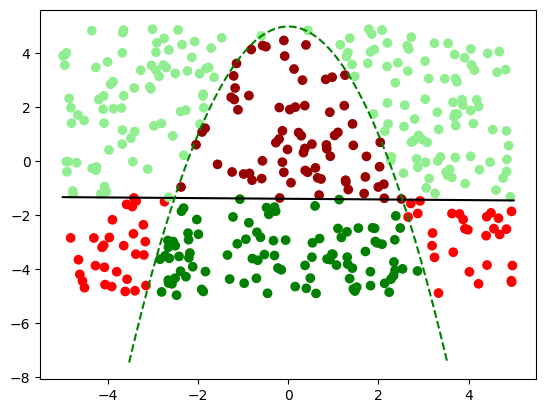

In [229]:
# from sympy import symbols
# s = clf.sympy_seperator()
# print(s(symbols('x')))
p.plotPred(clf.predict(X), clf.sympy_seperator())

# Training

In [14]:
from sympy import Lambda, Symbol
from training import matrix_train


x = Symbol("x")


# each axis must be an iterable. if you want to use a constant, wrap it in an iterable of len 1
hyperparameter_matrix = {
    "epochs": np.logspace(np.log10(100), np.log10(100000), num=20, dtype="int64"),
    "lr": np.logspace(np.log10(.00001), np.log10(.1), num=20),
    "hidden_layers": [5, 6, 7],
    "neurons_per_layer": [3],
    "activation": [Lambda(x, x**2)],
}

best_params = matrix_train(hyperparameter_matrix, MultiLayerPerceptron, X_train, y_train, X_test, y_test)

print(best_params)
# mlp = MultiLayerPerceptron(**best_params)


ModuleNotFoundError: No module named 'sympy'

# Performance

In [ ]:
from analysis import accuracy, confusion, report


mlp = MultiLayerPerceptron(**best_params)
mlp.fit(X_train, y_train)

# print(accuracy(mlp.predict(X_test), y_test))
# print(confusion(mlp.predict(X_test), y_test))
print(report(mlp.predict(X_test), y_test))


# Benchmarking

In [30]:
# TODO utilize other classifiers and compare performance
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.svm import SVC

In [29]:
v = CountVectorizer()
X_train_format = v.fit_transform(X_train[:10_000, 0])

In [32]:
clf = SVC(kernel='linear', random_state=42)
clf = clf.fit(X_train_format, y_train[:10_000])

In [35]:
X_validate_format = v.transform(X_validate[:, 0])
clf.score(X_validate_format, y_validate)

0.8509

In [38]:
x = np.array(["This company is great"])
x = v.transform(x)
clf.predict(x)

array(['positive'], dtype=object)